# XOR ANN Optimization using a Genetic Algorith vs Stochastic Gradient Descent

In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pt_fc_layers_viz import draw_pt_fc_layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib
from sklearn.metrics import confusion_matrix
import seaborn as sn

## Utility Functions

In [92]:
def determine_device():
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available():
        device = "mps" # Apple M1

    print(f"We are using device: {device}")
    return device

In [93]:
def plot_metric(train_metric, valid_metric, metric_name, legend_loc='upper right'):
    plt.plot(train_metric, label='Train ' + metric_name)
    plt.plot(valid_metric, label='Validation ' + metric_name)
    plt.ylabel(metric_name)
    plt.xlabel('Epoch')
    plt.legend(loc=legend_loc)
    plt.show()
    print(f'Train {metric_name} final value: {train_metric[-1]}')
    print(f'Validation {metric_name} final value: {valid_metric[-1]}')

In [94]:
def get_confusion_matrix(X, Y, model, label_encoder):
    y_pred = model(X)
    y_pred_max = torch.argmax(y_pred, dim=1)
    cm = confusion_matrix(Y, y_pred_max)
    plt.figure(figsize=(6, 4))
    sn.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    labels = label_encoder.classes_
    plt.xticks(np.arange(len(labels)) + 0.5, labels)
    plt.yticks(np.arange(len(labels)) + 0.5, labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [95]:
def print_true_vs_pred_class(X, Y, model, label_encoder):
    y_pred = model(X)
    y_pred_max = torch.argmax(y_pred, dim=1)
    def decode_label(label):
        return label_encoder.inverse_transform([label])[0]
    return [(decode_label(ytrue), decode_label(ypred)) for ytrue, ypred in zip(Y, y_pred_max) if ytrue != ypred]

## Evaluation Helpers

In [96]:
def get_accuracy_and_loss(model: nn.Module, X: torch.Tensor, Y: torch.Tensor, loss: float=None) -> (float, float):
    model.eval()
    with torch.no_grad():
        logits = model(X)
        Y_hat = torch.argmax(logits, dim=1)
        correct = (Y_hat == Y).sum().item()
        
        accuracy = correct / X.shape[0]

        if loss is None:
            loss = F.cross_entropy(logits, Y).item()

    return accuracy, loss

## Global Variables

In [97]:
# RANDOM_SEED = np.random.randint(0, 1000)
RANDOM_SEED = 17

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

## ANN

In [98]:
class ANN(nn.Module):
    def __init__(self, *, layers=[2, 2, 1], activation_fn=nn.ReLU, requires_grad=False):
        super().__init__()

        # Add each layer followed by the activation function
        module_list = []
        for i in range(len(layers) - 1):
            module_list.append(nn.Linear(layers[i], layers[i + 1]))
            if activation_fn is not None:
                module_list.append(activation_fn())
        if activation_fn is not None:
            module_list.pop() # The last layer should not have an activation function

        self.layers = nn.ModuleList(module_list)

        if requires_grad is False:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, x) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x)
        return x

## Data

In [99]:
iris = pd.read_csv('iris/iris.data', header=None)
X = iris.iloc[:, 0:4].values
Y = iris.iloc[:, 4].values

X.shape, Y.shape, X[0], Y[0]

((150, 4), (150,), array([5.1, 3.5, 1.4, 0.2]), 'Iris-setosa')

In [100]:
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)
joblib.dump(label_encoder, 'label_encoder-iris.joblib')
Y[0]

0

In [101]:
X_train_valid, X_test, Y_train_valid, Y_test = train_test_split(X, Y, test_size=0.15, random_state=RANDOM_SEED, shuffle=True, stratify=Y)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train_valid, Y_train_valid, test_size=0.3, random_state=RANDOM_SEED, shuffle=True, stratify=Y_train_valid)
X_train.shape, X_valid.shape, X_test.shape

((88, 4), (39, 4), (23, 4))

In [102]:
X_train = torch.from_numpy(X_train).float()
Y_train = torch.from_numpy(Y_train).long()
X_valid = torch.from_numpy(X_valid).float()
Y_valid = torch.from_numpy(Y_valid).long()
# X_test = torch.from_numpy(X_test).float()
# Y_test = torch.from_numpy(Y_test).long()

Y_train.shape, Y_train.dtype, Y_train[0]

(torch.Size([88]), torch.int64, tensor(1))

## Genetic Algorithm Optimization

### Torch Interaction

In [103]:
def get_all_parameters_as_vector(model: nn.Module) -> torch.Tensor:
    return torch.cat([p.flatten() for p in model.parameters()])

In [104]:
def set_all_parameters_from_vector(model: nn.Module, param_vector: torch.Tensor) -> nn.Module:
    position = 0
    for param in model.parameters():
        num_elements = param.numel()
        values_slice = param_vector[position:position+num_elements]
        param.data.copy_(values_slice.view(param.shape)) # A.copy_(B) copies B values into A
        position += num_elements
    return model

In [105]:
model_0 = ANN(layers=[2, 2, 1])
model_1 = ANN(layers=[2, 2, 1])
set_all_parameters_from_vector(model_1, get_all_parameters_as_vector(model_0))
assert get_all_parameters_as_vector(model_0).equal(get_all_parameters_as_vector(model_1))

### Popultation Initialization

In [107]:
# Could be optimized by using torch internals to initialize parameters instead of creating lots of models.

def get_population_he(model: nn.Module, size: int) -> torch.Tensor:
    layers = []
    for layer in model.layers:
        if isinstance(layer, nn.Linear):
            layers.append(layer.in_features)
    layers = layers + [model.layers[-1].out_features]

    activation_fn = type(model.layers[1])

    requires_grad = model.layers[0].weight.requires_grad
    
    param_pop = []
    for _ in range(size):
        model = ANN(layers=layers, activation_fn=activation_fn, requires_grad=requires_grad)
        
        params = get_all_parameters_as_vector(model)
        param_pop.append(params)

    return torch.stack(param_pop)

In [110]:
# Get random parameters in the range init_range

# def get_population(model: nn.Module, size: int) -> torch.Tensor:
#     original_params = get_all_parameters_as_vector(model)
#     n_params = original_params.numel()
    
#     param_sets = []
#     for _ in range(size):
#         new_params = (torch.rand(n_params) * 2) - 1
#         param_sets.append(new_params)

#     return torch.stack(param_sets)

# In-place version
def get_population(model: nn.Module, size: int, init_range=.5) -> torch.Tensor:
    original_params = get_all_parameters_as_vector(model)
    n_params = original_params.numel()
    
    param_pop = torch.empty(size, n_params)
    
    for i in range(size):
        param_pop[i].uniform_(-init_range, init_range)

    return param_pop

### Fitness Function

In [112]:
def get_fitness(population: torch.Tensor, model: nn.Module, X: torch.Tensor, Y: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    # Rank means the position of the individual in the population. High rank -> low loss. population[ranks[0]] is the individual with the lowest loss.
    
    losses = []
    for individual in population:
        model = set_all_parameters_from_vector(model, individual)
        _, loss = get_accuracy_and_loss(model, X, Y)
        losses.append(loss)

    losses = torch.Tensor(losses)
    _, ranks = torch.sort(torch.argsort(losses, descending=True))

    return losses, ranks

### Selection

In [115]:
def exp_rank_selection(population: torch.Tensor, percentage: float, ranks: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    n_selected = int(percentage * population.shape[0])
    
    # P(i) = (1 - e ^ -i) / c
    # i is the fitness rank and c is a normalization constant according to the population size
    probabilities_without_norm = 1 - torch.exp(-ranks)
    c = probabilities_without_norm.sum()
    selection_probabilities = probabilities_without_norm / c

    selected_indices = torch.multinomial(selection_probabilities, n_selected, replacement=True) # replacement=True means that the same index can be selected multiple times
    
    selected_individuals = population[selected_indices]
    return selected_individuals

In [120]:
def roulette_wheel_selection(population: torch.Tensor, percentage: float, ranks: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    selection_probabilities = ranks / ranks.sum()
    n_selected = int(percentage * population.shape[0])
    
    selected_indices = torch.multinomial(selection_probabilities, n_selected, replacement=True)
    
    selected_individuals = population[selected_indices]
    return selected_individuals

### Crossover

In [125]:
def mean_cross(individuals: torch.Tensor, n_offspring: int) -> torch.Tensor:
    parent_1_indices = torch.randint(individuals.shape[0], size=(n_offspring,))
    parent_2_indices = torch.randint(individuals.shape[0], size=(n_offspring,))
    
    parent_1 = individuals[parent_1_indices]
    parent_2 = individuals[parent_2_indices]
    
    offspring = parent_1.add_(parent_2).div_(2) # Like `(parent_1 + parent_2) / 2` but in-place (faster)

    return offspring

In [128]:
def one_point_cross(individuals: torch.Tensor, n_offspring: int) -> torch.Tensor:
    parent_1_indices = torch.randint(individuals.shape[0], size=(n_offspring,))
    parent_2_indices = torch.randint(individuals.shape[0], size=(n_offspring,))
    
    parent_1 = individuals[parent_1_indices]
    parent_2 = individuals[parent_2_indices]
    
    crossover_point = torch.randint(individuals.shape[1], size=(1,)).item()

    offspring = torch.cat((parent_1[:, :crossover_point], parent_2[:, crossover_point:]), dim=1)

    return offspring

### Mutation

In [132]:
# def mutate_population(population: torch.Tensor, mutation_rate: float, mutation_range=0.5) -> torch.Tensor:
#     total_cells = population.numel()
#     n_mutations = int(mutation_rate * total_cells)
#     print(f"Mutating {n_mutations} cells out of {total_cells}")

#     cell_indices = torch.randperm(total_cells)[:n_mutations]

#     for index in cell_indices:
#         row = index // population.shape[1]
#         col = index % population.shape[1]
#         population[row, col].uniform_(-mutation_range, mutation_range)
    
#     return population

# Optimized version: no for loop, no random permutation, rows and cols are calculated in one go
def mutate_population(population: torch.Tensor, mutation_rate: float, mutation_range=0.5) -> torch.Tensor:
    total_cells = population.numel()
    n_mutations = int(mutation_rate * total_cells)

    cell_indices = torch.randint(0, total_cells, (n_mutations,), dtype=torch.long)

    rows = cell_indices // population.shape[1]
    cols = cell_indices % population.shape[1]

    mutations = torch.rand(n_mutations).uniform_(-mutation_range, mutation_range)
    population[rows, cols] += mutations

    return population

### Algorithm

In [135]:
# --- problem parameters
MAX_EPOCHS = 500
LAYERS = [4, 8, 3]
PRINT_EVERY_N_EPOCHS = 100
EARLY_STOP_N_EPOCHS_SAME_ACC = 100

DEBUG = True
DRAW_ANN = False

trial_results = []
def objective(trial):
    # --- tunable hyperparameters
    POPULATION_SIZE = trial.suggest_categorical('population_size', [500, 1000, 1500, 2000])
    ELITISM_PCT = trial.suggest_float('elitism_pct', 0.0, 0.3, step=0.1)
    POP_INIT_METHOD = trial.suggest_categorical('pop_init_method', ['random', 'he'])
    POP_INIT_RANDOM_RANGE = trial.suggest_float('pop_init_random_range', 0.7, 1.1, step=0.1)
    PARENT_SELECTION_METHOD = trial.suggest_categorical('parent_selection_method', ['roulette_wheel', 'exp_rank'])
    PARENT_SELECTION_PCT = trial.suggest_float('parent_selection_pct', 0.4, 0.6, step=0.1)
    INIT_PARENT_MUTATION_RANGE = trial.suggest_float('init_parent_mutation_range', 0.3, 0.5, step=0.1)
    PARENT_MUTATION_RATE = trial.suggest_categorical('parent_mutation_rate', [0.01, 0.05, 0.1])
    CROSSOVER_METHOD = trial.suggest_categorical('crossover_method', ['one_point', 'mean'])
    CROSSOVER_NUM_OFFSPRING = trial.suggest_categorical('crossover_num_offspring', [100, 200, 300])
    INIT_OFFSPRING_MUTATION_RANGE = trial.suggest_float('init_offspring_mutation_range', 0.5, 0.7, step=0.1)
    OFFSPRING_MUTATION_RATE = trial.suggest_categorical('parent_mutation_rate', [0.01, 0.05, 0.1])
    POP_SELECTION_METHOD = trial.suggest_categorical('pop_selection_method', ['roulette_wheel', 'exp_rank'])
    MUTATION_RANGES_REDUCTION_FACTOR = trial.suggest_float('mutation_ranges_reduction_factor', 0.2, 0.5, step=0.1)
    JOINT_ERR_TRESHOLD_DIV = trial.suggest_categorical('joint_err_divider', [2, 3, 5, 10, 20, 30])

    # --- initialization
    starttime = datetime.datetime.now()
    model = ANN(layers=LAYERS, activation_fn=nn.Tanh)
    if POP_INIT_METHOD == 'random':
        population = get_population(model, POPULATION_SIZE, POP_INIT_RANDOM_RANGE)
    elif POP_INIT_METHOD == 'he':
        population = get_population_he(model, POPULATION_SIZE)
    
    print(f'Trial {trial.number + 1}: Population initialized with method {POP_INIT_METHOD}{f" (initializaiton range +/-{POP_INIT_RANDOM_RANGE})" if POP_INIT_METHOD == "random" else ""}')
    print(f'Pop size: {POPULATION_SIZE}, '
      f'Elite %: {ELITISM_PCT:.1f}, '
      f'Par sel method: {PARENT_SELECTION_METHOD}, '
      f'Par sel %: {PARENT_SELECTION_PCT:.1f}, '
      f'Par mut range: {INIT_PARENT_MUTATION_RANGE:.1f}, '
      f'Par mut rate: {PARENT_MUTATION_RATE}, '
      f'Cross method: {CROSSOVER_METHOD}, '
      f'Cross size: {CROSSOVER_NUM_OFFSPRING}, '
      f'Off mut range: {INIT_OFFSPRING_MUTATION_RANGE:.1f}, '
      f'Off mut rate: {OFFSPRING_MUTATION_RATE}, '
      f'Pop sel method: {POP_SELECTION_METHOD}, '
      f'Mut ranges red fact: {MUTATION_RANGES_REDUCTION_FACTOR:.1f}',
      f'Joint err tresh div: {JOINT_ERR_TRESHOLD_DIV}')

    # --- training
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    best_individual = None

    losses, ranks = get_fitness(population, model=model, X=X_train, Y=Y_train)
    DRAW_ANN and draw_pt_fc_layers(set_all_parameters_from_vector(model, population[ranks[0]]))
    pop_init_loss = losses.mean().item()

    joint_err_tracker = 3
    parent_mutation_range_tracker = INIT_PARENT_MUTATION_RANGE
    offspring_mutation_range_tracker = INIT_OFFSPRING_MUTATION_RANGE
    did_early_stop_without_success = False

    print(f"Starting training with random seed {RANDOM_SEED}. Initiation mean population loss: {pop_init_loss:6f}")

    for epoch in range(MAX_EPOCHS):
        assert population.shape[0] == POPULATION_SIZE, f"Population size is {population.shape[0]} but should be {POPULATION_SIZE}"
        assert ranks.shape[0] == POPULATION_SIZE, f"Ranks size is {ranks.shape[0]} but should be {POPULATION_SIZE}"

        if ELITISM_PCT > 0:
            n_elites = int(ELITISM_PCT * POPULATION_SIZE)
            elites = population[ranks][:n_elites]

        if PARENT_SELECTION_METHOD == 'exp_rank':
            parents = exp_rank_selection(population, PARENT_SELECTION_PCT, ranks)
        elif PARENT_SELECTION_METHOD == 'roulette_wheel':
            parents = roulette_wheel_selection(population, PARENT_SELECTION_PCT, ranks)

        if CROSSOVER_METHOD == 'one_point':
            offspring = one_point_cross(parents, CROSSOVER_NUM_OFFSPRING)
        elif CROSSOVER_METHOD == 'mean':
            offspring = mean_cross(parents, CROSSOVER_NUM_OFFSPRING)
        
        if PARENT_MUTATION_RATE > 0 and parent_mutation_range_tracker > 0:
            parents = mutate_population(parents, PARENT_MUTATION_RATE, parent_mutation_range_tracker)
        if OFFSPRING_MUTATION_RATE > 0 and offspring_mutation_range_tracker > 0:
            offspring = mutate_population(offspring, OFFSPRING_MUTATION_RATE, offspring_mutation_range_tracker)
        population = torch.cat([parents, offspring])
        
        losses, ranks = get_fitness(population, model=model, X=X_train, Y=Y_train)

        percentage = (POPULATION_SIZE - n_elites) / population.shape[0] if ELITISM_PCT > 0 else POPULATION_SIZE / population.shape[0]
        if POP_SELECTION_METHOD == 'roulette_wheel':
            population = roulette_wheel_selection(population, percentage, ranks)
        elif POP_SELECTION_METHOD == 'exp_rank':
            population = exp_rank_selection(population, percentage, ranks)

        if ELITISM_PCT > 0:
            population = torch.cat([elites, population])

        if population.shape[0] != POPULATION_SIZE:
            population = torch.cat([population, parents[:POPULATION_SIZE - population.shape[0]]])
        
        losses, ranks = get_fitness(population, model=model, X=X_train, Y=Y_train)
        mean_loss = losses.mean().item()

        best_individual = population[ranks[0]]
        best_model = set_all_parameters_from_vector(model, best_individual)
        train_acc, train_loss = get_accuracy_and_loss(best_model, X_train, Y_train)
        valid_acc, valid_loss = get_accuracy_and_loss(best_model, X_valid, Y_valid)
        train_losses.append(train_loss), train_accuracies.append(train_acc)
        valid_losses.append(valid_loss), valid_accuracies.append(valid_acc)
        
        if train_acc == 1 and valid_acc == 1:
            print(f'Early stopping on epoch {epoch + 1} because accuracies are 1')
            break

        joint_err = 2 - valid_acc - train_acc + min(1, valid_loss)
        if DEBUG and (epoch + 1) % PRINT_EVERY_N_EPOCHS == 0:
            print(f"Epoch {epoch + 1}, best individual train loss: {train_loss:4f}, valid loss: {valid_loss:4f}, train acc: {train_acc:4f}, valid acc: {valid_acc:4f}, joint err: {joint_err:4f}")
            DRAW_ANN and draw_pt_fc_layers(best_model)

        if torch.Tensor(train_accuracies[-EARLY_STOP_N_EPOCHS_SAME_ACC:]).std() < 1e-6 and torch.Tensor(valid_accuracies[-EARLY_STOP_N_EPOCHS_SAME_ACC:]).std() < 1e-6:
            print(f'Early stopping on epoch {epoch + 1} because accuracies have been the same for {EARLY_STOP_N_EPOCHS_SAME_ACC} epochs. Train acc: {train_acc:4f}, valid acc: {valid_acc:4f}')
            did_early_stop_without_success = True
            break

        if joint_err < joint_err_tracker / JOINT_ERR_TRESHOLD_DIV:
            offspring_mutation_range_tracker *= MUTATION_RANGES_REDUCTION_FACTOR
            parent_mutation_range_tracker *= MUTATION_RANGES_REDUCTION_FACTOR
            print(f"Joint error is below {joint_err_tracker / JOINT_ERR_TRESHOLD_DIV:6f}, reducing mutation range to {offspring_mutation_range_tracker:6f}(p) and {parent_mutation_range_tracker:6f}(o)")
            joint_err_tracker = joint_err

    goodness = (1e-5 + joint_err) * 2 + (1 if did_early_stop_without_success else ((epoch + 1) / MAX_EPOCHS))

    total_time_s = (datetime.datetime.now() - starttime).total_seconds()
    print(f"Final results in epoch {epoch + 1}: train acc: {train_acc:4f}, valid acc: {valid_acc:4f}, time: {total_time_s/60:.2f}m, goodness: {goodness:.4f}")

    trial_results.append({
        'pop_init_loss': pop_init_loss,
        'pop_final_loss': mean_loss,
        'final_train_acc': train_acc,
        'final_train_loss': train_loss,
        'final_valid_acc': valid_acc,
        'final_valid_loss': valid_loss,
        'final_joint_err': joint_err,
        'epochs': epoch + 1,
        'max_epochs': MAX_EPOCHS,
        'total_time_s': total_time_s,
        'goodness': goodness,
        'population_size': POPULATION_SIZE,
        'elitism_pct': ELITISM_PCT,
        'pop_init_method': POP_INIT_METHOD,
        'pop_init_random_range': POP_INIT_RANDOM_RANGE,
        'parent_selection_method': PARENT_SELECTION_METHOD,
        'parent_selection_pct': PARENT_SELECTION_PCT,
        'init_parent_mutation_range': INIT_PARENT_MUTATION_RANGE,
        'parent_mutation_range_tracker': parent_mutation_range_tracker,
        'parent_mutation_rate': PARENT_MUTATION_RATE,
        'crossover_method': CROSSOVER_METHOD,
        'crossover_num_offspring': CROSSOVER_NUM_OFFSPRING,
        'init_offspring_mutation_range': INIT_OFFSPRING_MUTATION_RANGE,
        'offspring_mutation_range_tracker': offspring_mutation_range_tracker,
        'offspring_mutation_rate': OFFSPRING_MUTATION_RATE,
        'pop_selection_method': POP_SELECTION_METHOD,
        'mutation_ranges_reduction_factor': MUTATION_RANGES_REDUCTION_FACTOR,
        'joint_err_treshold_div': JOINT_ERR_TRESHOLD_DIV,
        'layers': LAYERS,
        'random_seed': RANDOM_SEED,
        'best_train_losses': train_losses,
        'best_train_accuracies': train_accuracies,
        'best_valid_losses': valid_losses,
        'best_valid_accuracies': valid_accuracies,
        'best_individual_params': best_individual,
    })
    
    return goodness

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=400)

print(f'Finished study with {len(study.trials)} trials. Best (lowest) goodness: {study.best_value:.2f}, best params: {study.best_params}')

df = pd.DataFrame(trial_results)
try:
    df_existing = pd.read_csv('results-iris.csv')
    print('Loaded existing results-iris.csv')
    df = pd.concat([df_existing, df])
except FileNotFoundError:
    pass
df = df.sort_values('goodness', ascending=True)
df.to_csv('results-iris.csv', index=False)
print('Saved results to results-iris.csv')

Trial 1: Population initialized with method he
Pop size: 500, Elite %: 0.1, Par sel method: roulette_wheel, Par sel %: 0.6, Par mut range: 0.5, Par mut rate: 0.1, Cross method: mean, Cross size: 300, Off mut range: 0.6, Off mut rate: 0.1, Pop sel method: exp_rank, Mut ranges red fact: 0.5 Joint err tresh div: 2
Starting training with random seed 17. Initiation mean population loss: 1.187234


Joint error is below 1.500000, reducing mutation range to 0.300000(p) and 0.250000(o)
Joint error is below 0.738804, reducing mutation range to 0.150000(p) and 0.125000(o)
Epoch 100, best individual train loss: 0.453319, valid loss: 0.464845, train acc: 0.954545, valid acc: 0.974359, joint err: 0.535941
Joint error is below 0.355298, reducing mutation range to 0.075000(p) and 0.062500(o)
Epoch 200, best individual train loss: 0.362993, valid loss: 0.373515, train acc: 0.829545, valid acc: 0.820513, joint err: 0.723457
Early stopping on epoch 289 because accuracies have been the same for 100 epochs. Train acc: 0.829545, valid acc: 0.820513
Final results in epoch 289: train acc: 0.829545, valid acc: 0.820513, time: 0.42m, goodness: 2.4469
Trial 2: Population initialized with method random (initializaiton range +/-0.7)
Pop size: 500, Elite %: 0.0, Par sel method: exp_rank, Par sel %: 0.5, Par mut range: 0.5, Par mut rate: 0.01, Cross method: mean, Cross size: 100, Off mut range: 0.5, Off 

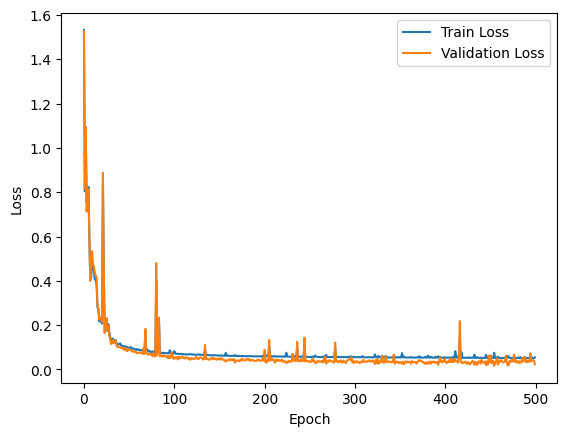

Train Loss final value: 0.054076481610536575
Validation Loss final value: 0.023515669628977776


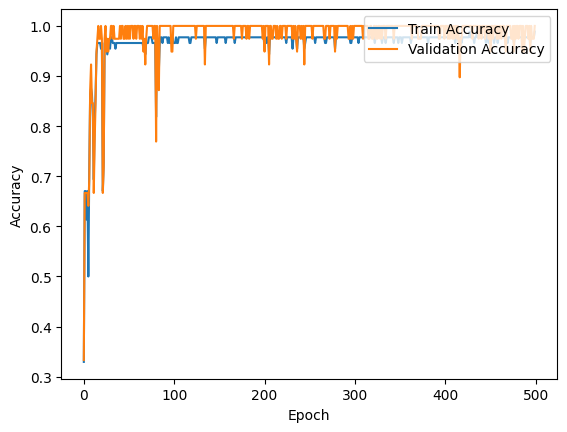

Train Accuracy final value: 0.9886363636363636
Validation Accuracy final value: 1.0


In [136]:
best_trial_values = trial_results[study.best_trial.number]

plot_metric(best_trial_values['best_train_losses'], best_trial_values['best_valid_losses'], 'Loss')
plot_metric(best_trial_values['best_train_accuracies'], best_trial_values['best_valid_accuracies'], 'Accuracy')

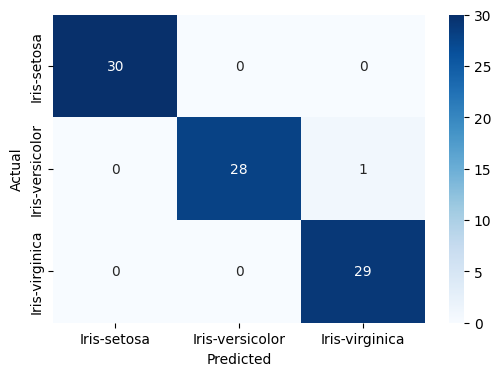

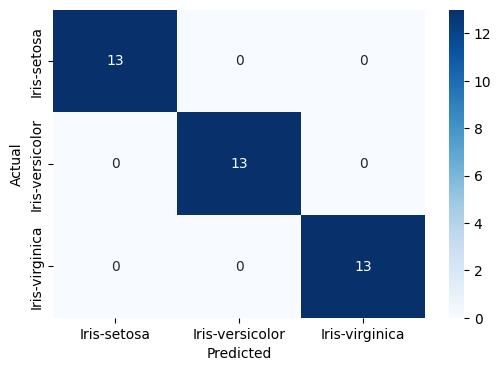

(None, None)

In [146]:
best_individual_params = best_trial_values['best_individual_params']
best_model = set_all_parameters_from_vector(ANN(layers=LAYERS, activation_fn=nn.Tanh), best_individual_params)
get_confusion_matrix(X_train, Y_train, best_model, label_encoder), get_confusion_matrix(X_valid, Y_valid, best_model, label_encoder)

In [147]:
print_true_vs_pred_class(X_train, Y_train, best_model, label_encoder)

[('Iris-versicolor', 'Iris-virginica')]

In [148]:
print_true_vs_pred_class(X_valid, Y_valid, best_model, label_encoder)

[]

## Gradient Descent Optimization

In [202]:
MAX_EPOCHS = 50000
PRINT_EVERY_N_EPOCHS = 2000
EARLY_STOP_N_EPOCHS_SAME_LOSS = 2000
LAYERS = [4, 8, 3]
DRAW_ANN = False
DEBUG = False

trial_results_gd = []
def objective(trial):
    LR = trial.suggest_categorical('lr', [0.1, 0.01, 0.05, 0.001, 0.005, 0.0001])
    MOMENTUM = trial.suggest_float('momentum', 0.1, 0.9, step=0.1)
    WEIGHT_DECAY = trial.suggest_categorical('weight_decay', [0.0, 0.001, 0.005, 0.0001, 0.0005])
    PATIENCE = trial.suggest_categorical('patience', [10, 50, 100, 500, 1000, 5000, 10000])

    model = ANN(layers=LAYERS, requires_grad=True, activation_fn=nn.Tanh)
    optimizer = torch.optim.SGD(model.parameters(), lr = LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=PATIENCE, verbose=True if DEBUG else False)

    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    best_valid_acc = 0
    best_model = None
    for epoch in range(MAX_EPOCHS): 

        y_hat = model(X_train)

        loss = F.cross_entropy(y_hat, Y_train)

        optimizer.zero_grad()

        loss.backward()

        train_acc, train_loss = get_accuracy_and_loss(model, X_train, Y_train)
        valid_acc, valid_loss = get_accuracy_and_loss(model, X_valid, Y_valid)
        train_losses.append(train_loss), train_accuracies.append(train_acc)
        valid_losses.append(valid_loss), valid_accuracies.append(valid_acc)

        optimizer.step()

        scheduler.step(valid_loss) 

        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            best_model = model

        if train_acc == 1 and valid_acc == 1:
            print(f'Early stopping on epoch {epoch} with loss {loss:.4f}, because accuracies are 1')
            break

        if epoch % PRINT_EVERY_N_EPOCHS == 0:
            DEBUG and print(f'Epoch {epoch + 1}, train loss: {loss:.4f}, valid loss: {valid_loss:.4f}, train acc: {train_acc:.4f}, valid acc: {valid_acc:.4f}')
            DRAW_ANN and draw_pt_fc_layers(model)

        if torch.Tensor(train_losses[-EARLY_STOP_N_EPOCHS_SAME_LOSS:]).std() < 1e-6 and torch.Tensor(valid_losses[-EARLY_STOP_N_EPOCHS_SAME_LOSS:]).std() < 1e-6:
            print(f'Early stopping on epoch {epoch} because losses have been the same for {EARLY_STOP_N_EPOCHS_SAME_LOSS} epochs')
            break

    print(f'Final train loss: {train_loss:.4f}, valid loss: {valid_loss:.4f}, train acc: {train_acc:.4f}, valid acc: {valid_acc:.4f}')

    trial_results_gd.append({
        'final_train_acc': train_acc,
        'final_train_loss': train_loss,
        'final_valid_acc': valid_acc,
        'final_valid_loss': valid_loss,
        'epochs': epoch + 1,
        'lr': LR,
        'momentum': MOMENTUM,
        'weight_decay': WEIGHT_DECAY,
        'patience': PATIENCE,
        'max_epochs': MAX_EPOCHS,
        'layers': LAYERS,
        'random_seed': RANDOM_SEED,
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'valid_losses': valid_losses,
        'valid_accuracies': valid_accuracies,
        'best_weights': get_all_parameters_as_vector(best_model),
    })

    return 3 - (2 * valid_acc + train_acc)

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print(f'Finished study with {len(study.trials)} trials. Best (lowest) loss: {study.best_value:.2f}, best params: {study.best_params}')

df = pd.DataFrame(trial_results_gd)
try:
    df_existing = pd.read_csv('results-iris-gd.csv')
    print('Loaded existing results-iris-gd.csv')
    df = pd.concat([df_existing, df])
except FileNotFoundError:
    pass
df = df.sort_values('final_valid_loss', ascending=True)
df.to_csv('results-iris-gd.csv', index=False)
print('Saved results to results-iris-gd.csv')

Final train loss: 0.3069, valid loss: 0.3236, train acc: 0.9659, valid acc: 0.9744
Final train loss: 0.0462, valid loss: 0.0706, train acc: 0.9773, valid acc: 0.9744
Final train loss: 0.0594, valid loss: 0.0451, train acc: 0.9773, valid acc: 1.0000
Early stopping on epoch 6677 because losses have been the same for 2000 epochs
Final train loss: 0.0550, valid loss: 0.0450, train acc: 0.9773, valid acc: 1.0000
Final train loss: 0.3807, valid loss: 0.3944, train acc: 0.9659, valid acc: 0.9744
Final train loss: 0.0552, valid loss: 0.0414, train acc: 0.9773, valid acc: 1.0000
Final train loss: 0.0878, valid loss: 0.0752, train acc: 0.9773, valid acc: 1.0000
Final train loss: 0.0601, valid loss: 0.0460, train acc: 0.9773, valid acc: 1.0000
Final train loss: 0.0834, valid loss: 0.0720, train acc: 0.9659, valid acc: 1.0000
Early stopping on epoch 20344 because losses have been the same for 2000 epochs
Final train loss: 0.0598, valid loss: 0.0458, train acc: 0.9773, valid acc: 1.0000
Early stopp

In [203]:
best_trial_model = trial_results_gd[study.best_trial.number]['best_weights']
model = set_all_parameters_from_vector(ANN(layers=LAYERS, activation_fn=nn.Tanh), best_trial_model)

In [204]:
print_true_vs_pred_class(X_train, Y_train, model, label_encoder)

[('Iris-virginica', 'Iris-versicolor'), ('Iris-versicolor', 'Iris-virginica')]

In [205]:
print_true_vs_pred_class(X_valid, Y_valid, model, label_encoder)

[]

In [216]:
trial_results_gd[study.best_trial.number]['final_valid_acc'], trial_results_gd[study.best_trial.number]['final_train_acc']

(1.0, 0.9772727272727273)

In [217]:
# hyperparameters
trial_results_gd[study.best_trial.number]['lr'], trial_results_gd[study.best_trial.number]['momentum'], trial_results_gd[study.best_trial.number]['weight_decay'], trial_results_gd[study.best_trial.number]['patience']

(0.01, 0.8, 0.001, 5000)

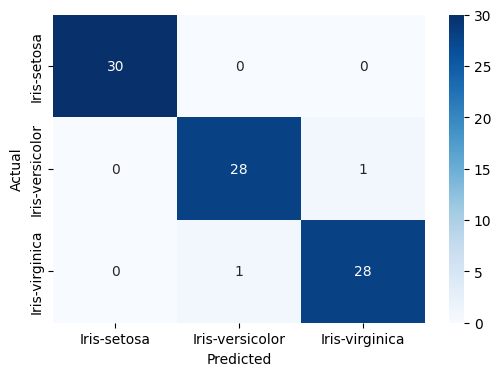

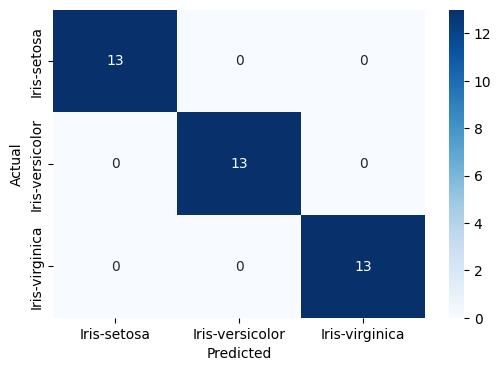

(None, None)

In [206]:
get_confusion_matrix(X_train, Y_train, model, label_encoder), get_confusion_matrix(X_valid, Y_valid, model, label_encoder)

In [207]:
train_losses = trial_results_gd[study.best_trial.number]['train_losses']
train_accuracies = trial_results_gd[study.best_trial.number]['train_accuracies']
valid_losses = trial_results_gd[study.best_trial.number]['valid_losses']
valid_accuracies = trial_results_gd[study.best_trial.number]['valid_accuracies']

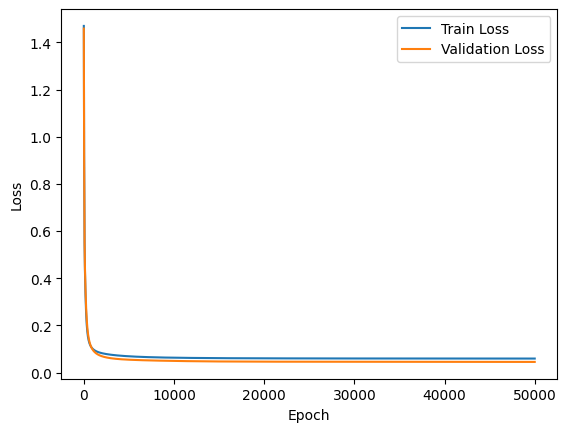

Train Loss final value: 0.05936640873551369
Validation Loss final value: 0.045095331966876984


In [208]:
plot_metric(train_losses, valid_losses, 'Loss')

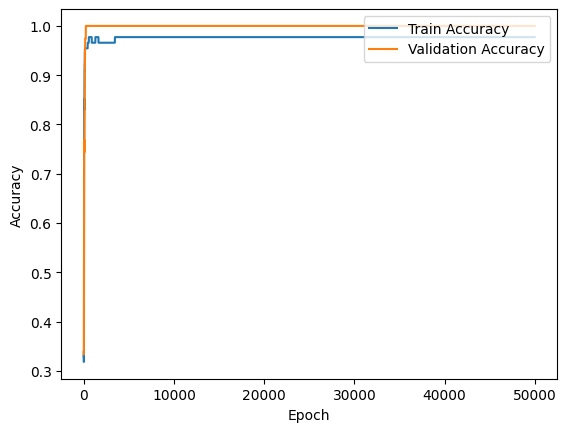

Train Accuracy final value: 0.9772727272727273
Validation Accuracy final value: 1.0


In [209]:
plot_metric(train_accuracies, valid_accuracies, 'Accuracy')